In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# for image
import matplotlib.pyplot as plt
import numpy as np

In [129]:
"""
- 데이터를 torch Tensor로 바꾸고 Normalization을 위해 transform.Compose 를 사용합니다.
- Compose 는 여러 transform 들을 chaining 합니다. 즉 여러 transform 진행합니다.
"""

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

"""
CIFAR10 training data를 ./data 에 다운로드 하고 tranfrom 을 진행합니다.
- [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- DataLoader 는 iterator를 반환합니다.
"""
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# test data 를 다운로드 합니다.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


# 클래스들은 뭐, (날아라 비행기, 아우디 r8, 날아라 병아리 아니고 벌드, 귀여운 고양이, 등 10개 입니다.)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [131]:
# [resnet](https://arxiv.org/abs/1512.03385)
net = models.resnet18()
# Cross Entropy loss 함수를 사용합니다.
criterion = nn.CrossEntropyLoss()

# stochastic gradient descent 를 사용합니다.
# [optim.SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

===> Testing before training...
input size:  torch.Size([4, 3, 224, 224])
output size:  torch.Size([4, 1000])
loss:  2.3245673179626465
    dog,     car,     cat,     cat


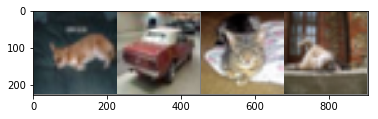

In [155]:
"""
그냥 한번 테스트 
"""
def test_for_batch(data, net):
    
    # batch size 만큼 이미지를 가져옵니다.
    inputs, labels = data

    # print(', '.join('%7s' % classes[labels[j]] for j in range(4)))
    print('input size: ', inputs.size())

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    print('output size: ', outputs.size())
    print('loss: ', loss.item())


    """
    이미지 보기
    """
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()     # numpy vector로 바꾸기
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # [make_grid](https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid)
    imshow(torchvision.utils.make_grid(inputs))

    print(', '.join('%7s' % classes[labels[j]] for j in range(4)))

    
print('===> Testing before training...')
test_for_batch(iter(trainloader).next(), net)

In [149]:
"""
GPU 사용하기
"""

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.device_count() > 1:
    print('Training on GPU!')
    net = nn.DataParallel(net)


In [150]:
epochs = 2 # dataset을 여러번 사용해 트레이닝을 시킵니다.

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        print("loss: ", loss.item())
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('===> Finished Training')

loss:  2.61187481880188
loss:  3.0600905418395996
loss:  2.223933458328247
loss:  3.6845154762268066
loss:  2.60345458984375
loss:  2.884416341781616


Process Process-183:
Process Process-184:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/won/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/won/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_

loss:  2.1199817657470703


KeyboardInterrupt: 

input size:  torch.Size([4, 3, 224, 224])
output size:  torch.Size([4, 1000])
loss:  2.4684462547302246
    cat,    ship,    ship,   plane

Predicted:   bird,   car,  bird,  bird


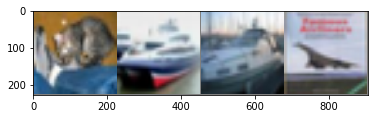

In [160]:
data = iter(testloader).next()
inputs, labels = data
test_for_batch(data, net)


outputs = net(inputs)
_, predicted = torch.max(outputs, 1)
print('\nPredicted: ', ', '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [161]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Process Process-204:
Process Process-203:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/won/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/won/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/won/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queu

KeyboardInterrupt: 

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))